In [30]:
import numpy as np
import pandas as pd
import csv
import math
from keras.utils import np_utils

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
def GenerateRawData(file_path): #Generate the Raw Feature Matrix and Target Vector
    data_target = []
    data_input = []
    x = pd.read_csv(file_path) 
    lenc = len(x.columns) #Obtain Number of features
    
    data_target = x['target'].tolist()

    data_input = x.iloc[:,2:lenc]
    
    data = np.array(data_input).T
    target = data_target

    return data,target

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):  #Splitting data to get Training target data
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80): #Splitting data to get Training feature data
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): #Splitting data to get Validation feature data
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): #Splitting data to get Validation target data
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    return t

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Nadam
import numpy as np
from datetime import datetime
from keras.layers.advanced_activations import LeakyReLU

def Neural_Network(file):
    RawData,RawTarget   = GenerateRawData(file)
    # Preparation of Training Data
    TrainingPercent = 80
    ValidationPercent = 10
    TestPercent = 20

    TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent)) #Prepare the target vector for training
#dataset
    TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent) #Prepare the Feature matrix for training dataset
    
    ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget)))) #Prepare the 
#Validation target vector
    ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))# Prepare the feature matrix for 
#Validation Dataset

    TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))#Prepare
#the Target vector for testing dataset
    TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))# Prepare the feature matrix 
#for Testing dataset

    
    # split into input (X) and output (Y) variables
    X = TrainingData.T
    Y = TrainingTarget
    # create model
    model = Sequential()
    #
    model.add(Dense(80, input_dim=X.shape[1], activation='relu'))
    
    #To prevent overfitting we add a Dropout layer
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    
    #Adding Second Hidden Layer with 35 nodes with Relu Activation Function
    model.add(Dense(35, activation='relu'))
    #Again add a Dropout to prevent overfitting
    model.add(Dropout(0.5, noise_shape=None, seed=None))
    
    #Adding the final layer with the final output by taking the Sigmoid Activation Function
    model.add(Dense(1, activation='sigmoid')) 
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model,X,Y,TestData,TestDataAct
    

In [53]:
def fit_model(model,X,Y,TestData,TestDataAct,Epochs,Batch):
    early_patience = 100
    batch_s = Batch
    #Gives no. of times data is sampled
    No_Epochs = Epochs
    #Divides the input into Training and Validation
    validation_data_split = 0.2
    #Tensorboard to give visualizations
    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= batch_s, write_graph= True)
    
    #To stop the training when a condition has met
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
    # Fit the model
    m = model.fit(X, Y, epochs=No_Epochs, batch_size=batch_s,validation_split=validation_data_split,  callbacks =  [tensorboard_cb,earlystopping_cb])
    # calculate predictions
    predictions = model.predict(TestData.T)
    # round predictions
    roundedPred = [round(x[0]) for x in predictions]
    # evaluate the model
    scores = model.evaluate(TestData.T, TestDataAct)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    %matplotlib inline
    df = pd.DataFrame(m.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))

Train on 2106 samples, validate on 527 samples
Epoch 1/200
2106/2106 [==============================] - 1s 288us/step - loss: 0.5926 - acc: 0.7346 - val_loss: 0.6188 - val_acc: 0.7116
Epoch 2/200
2106/2106 [==============================] - 0s 176us/step - loss: 0.5532 - acc: 0.7811 - val_loss: 0.6074 - val_acc: 0.7116
Epoch 3/200
2106/2106 [==============================] - 0s 177us/step - loss: 0.5379 - acc: 0.7844 - val_loss: 0.6066 - val_acc: 0.7116
Epoch 4/200
2106/2106 [==============================] - 0s 189us/step - loss: 0.5406 - acc: 0.7854 - val_loss: 0.6079 - val_acc: 0.7116
Epoch 5/200
2106/2106 [==============================] - 0s 168us/step - loss: 0.5387 - acc: 0.7858 - val_loss: 0.6101 - val_acc: 0.7116
Epoch 6/200
2106/2106 [==============================] - 0s 180us/step - loss: 0.5301 - acc: 0.7858 - val_loss: 0.6065 - val_acc: 0.7116
Epoch 7/200
2106/2106 [==============================] - 0s 185us/step - loss: 0.5280 - acc: 0.7858 - val_loss: 0.6149 - val_acc: 0

2106/2106 [==============================] - 0s 186us/step - loss: 0.4837 - acc: 0.7830 - val_loss: 0.6468 - val_acc: 0.7097
Epoch 61/200
2106/2106 [==============================] - 0s 180us/step - loss: 0.4821 - acc: 0.7920 - val_loss: 0.6629 - val_acc: 0.7116
Epoch 62/200
2106/2106 [==============================] - 0s 186us/step - loss: 0.4805 - acc: 0.7868 - val_loss: 0.6752 - val_acc: 0.7116
Epoch 63/200
2106/2106 [==============================] - 0s 177us/step - loss: 0.4790 - acc: 0.7915 - val_loss: 0.6368 - val_acc: 0.7097
Epoch 64/200
2106/2106 [==============================] - 0s 175us/step - loss: 0.4689 - acc: 0.7944 - val_loss: 0.6775 - val_acc: 0.7116
Epoch 65/200
2106/2106 [==============================] - 0s 176us/step - loss: 0.4661 - acc: 0.7930 - val_loss: 0.6593 - val_acc: 0.7097
Epoch 66/200
2106/2106 [==============================] - 0s 173us/step - loss: 0.4680 - acc: 0.7906 - val_loss: 0.6674 - val_acc: 0.7097
Epoch 67/200
2106/2106 [=======================

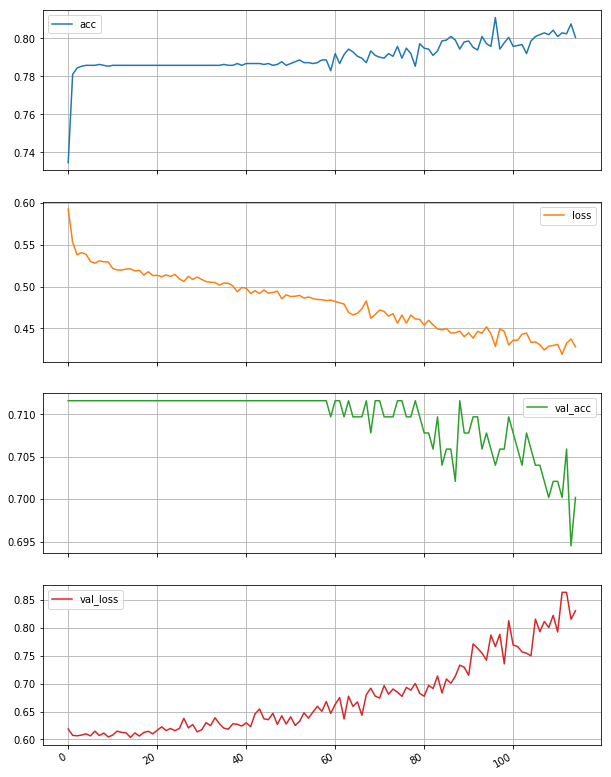

In [54]:
model,X,Y,T,TA = Neural_Network('HumanFeatureData.csv')
fit_model(model,X,Y,T,TA,200,10)

Train on 1530 samples, validate on 383 samples
Epoch 1/200
1530/1530 [==============================] - 1s 508us/step - loss: 0.6830 - acc: 0.6131 - val_loss: 0.6318 - val_acc: 0.6919
Epoch 2/200
1530/1530 [==============================] - 0s 262us/step - loss: 0.6622 - acc: 0.6471 - val_loss: 0.6340 - val_acc: 0.6919
Epoch 3/200
1530/1530 [==============================] - 0s 321us/step - loss: 0.6530 - acc: 0.6542 - val_loss: 0.6268 - val_acc: 0.6919
Epoch 4/200
1530/1530 [==============================] - 1s 356us/step - loss: 0.6460 - acc: 0.6582 - val_loss: 0.6302 - val_acc: 0.6919
Epoch 5/200
1530/1530 [==============================] - 1s 405us/step - loss: 0.6457 - acc: 0.6575 - val_loss: 0.6346 - val_acc: 0.6919
Epoch 6/200
1530/1530 [==============================] - 1s 359us/step - loss: 0.6453 - acc: 0.6601 - val_loss: 0.6350 - val_acc: 0.6919
Epoch 7/200
1530/1530 [==============================] - 0s 283us/step - loss: 0.6405 - acc: 0.6601 - val_loss: 0.6320 - val_acc: 0

1530/1530 [==============================] - 0s 289us/step - loss: 0.5986 - acc: 0.6863 - val_loss: 0.6513 - val_acc: 0.6606
Epoch 61/200
1530/1530 [==============================] - 1s 377us/step - loss: 0.6083 - acc: 0.6758 - val_loss: 0.6519 - val_acc: 0.6632
Epoch 62/200
1530/1530 [==============================] - 0s 325us/step - loss: 0.5999 - acc: 0.6739 - val_loss: 0.6468 - val_acc: 0.6710
Epoch 63/200
1530/1530 [==============================] - 1s 421us/step - loss: 0.5928 - acc: 0.6948 - val_loss: 0.6546 - val_acc: 0.6606
Epoch 64/200
1530/1530 [==============================] - 1s 368us/step - loss: 0.5985 - acc: 0.6791 - val_loss: 0.6607 - val_acc: 0.6554
Epoch 65/200
1530/1530 [==============================] - 1s 389us/step - loss: 0.6050 - acc: 0.6693 - val_loss: 0.6517 - val_acc: 0.6684
Epoch 66/200
1530/1530 [==============================] - 1s 360us/step - loss: 0.5947 - acc: 0.6810 - val_loss: 0.6555 - val_acc: 0.6684
Epoch 67/200
1530/1530 [=======================

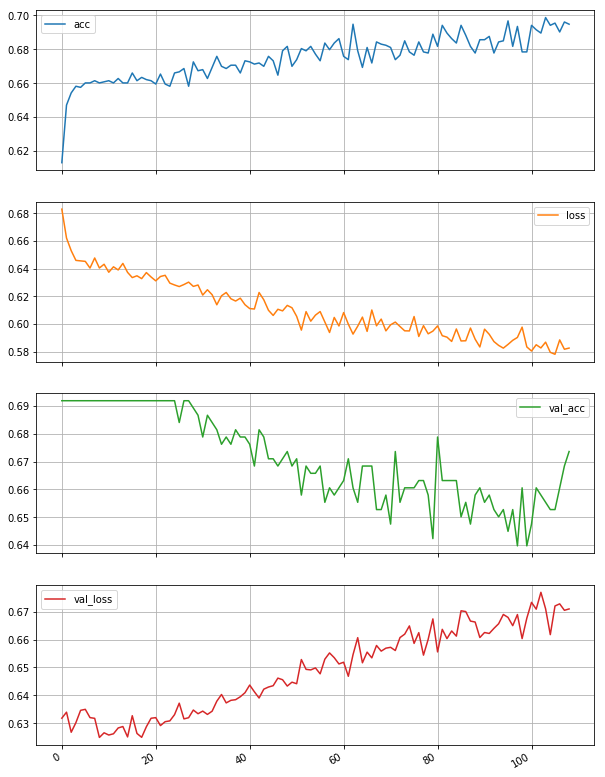

In [56]:
model,X,Y,T,TA = Neural_Network('HumanFeatureDataSub.csv')
fit_model(model,X,Y,T,TA,200,10)

Train on 1920 samples, validate on 480 samples
Epoch 1/200
1920/1920 [==============================] - 1s 389us/step - loss: 0.0215 - acc: 0.9922 - val_loss: 12.7165 - val_acc: 0.1667
Epoch 2/200
1920/1920 [==============================] - 0s 257us/step - loss: 3.1866e-04 - acc: 1.0000 - val_loss: 13.3352 - val_acc: 0.1667
Epoch 3/200
1920/1920 [==============================] - 1s 268us/step - loss: 1.7464e-04 - acc: 1.0000 - val_loss: 13.4079 - val_acc: 0.1667
Epoch 4/200
1920/1920 [==============================] - 1s 262us/step - loss: 1.6978e-04 - acc: 1.0000 - val_loss: 13.4247 - val_acc: 0.1667
Epoch 5/200
1920/1920 [==============================] - 1s 263us/step - loss: 1.1204e-04 - acc: 1.0000 - val_loss: 13.4274 - val_acc: 0.1667
Epoch 6/200
1920/1920 [==============================] - 0s 254us/step - loss: 2.5785e-05 - acc: 1.0000 - val_loss: 13.4287 - val_acc: 0.1667
Epoch 7/200
1920/1920 [==============================] - 1s 283us/step - loss: 1.3416e-05 - acc: 1.0000 -

1920/1920 [==============================] - 0s 246us/step - loss: 1.0017e-07 - acc: 1.0000 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 59/200
1920/1920 [==============================] - 0s 249us/step - loss: 1.0778e-07 - acc: 1.0000 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 60/200
1920/1920 [==============================] - 1s 279us/step - loss: 1.0112e-07 - acc: 1.0000 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 61/200
1920/1920 [==============================] - 1s 289us/step - loss: 1.0046e-07 - acc: 1.0000 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 62/200
1920/1920 [==============================] - 1s 287us/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 63/200
1920/1920 [==============================] - 1s 291us/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 64/200
1920/1920 [==============================] - 1s 279us/step - loss: 1.0072e-07 - acc: 1.0000 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 65/200

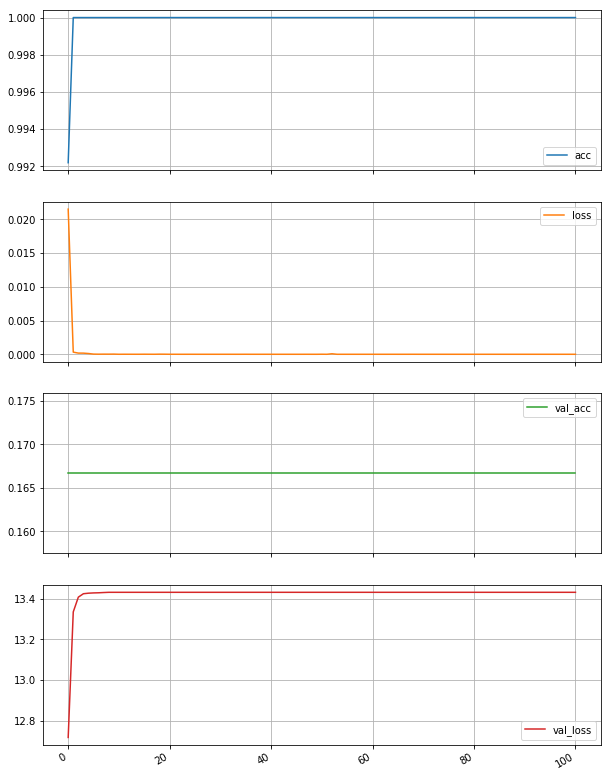

In [57]:
model,X,Y,T,TA = Neural_Network('GSCFeatureData.csv')
fit_model(model,X,Y,T,TA,200,10)

In [ ]:
model,X,Y,T,TA = Neural_Network('GSCFeatureDataSub.csv')
fit_model(model,X,Y,T,TA,200,10)